In [1]:

from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate
import numpy as np

# Load the datasets
train_data = load_dataset('json', data_files='en_train.jsonl')['train']
dev_data = load_dataset('json', data_files='en_dev.jsonl')['train']
test_data = load_dataset('json', data_files='en_devtest.jsonl')['train']

# Initialize the tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

# Preprocessing function
def preprocess_t5_data(examples):
    inputs = examples['text']  # Input text
    labels = examples['label']  # Labels

    # Ensure inputs are strings
    inputs = [f"detect content: {text}" for text in inputs]
    labels = [str(label) for label in labels]  # Convert labels to strings

    # Tokenize inputs and labels
    model_inputs = t5_tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = t5_tokenizer(labels, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]  # Add tokenized labels
    return model_inputs

# Preprocess the datasets
train_data = train_data.map(preprocess_t5_data, batched=True)
dev_data = dev_data.map(preprocess_t5_data, batched=True)
test_data = test_data.map(preprocess_t5_data, batched=True)

# Set format for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
dev_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load the model
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Define training arguments
t5_training_args = TrainingArguments(
    output_dir="./fine_tuned_model_t5/t5_results",  # Directory to save T5 results
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./results_t5/t5_logs",  # Logging directory for T5
    logging_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Use loss as the metric for best model
    greater_is_better=False,
    seed=42,
    fp16=True,
)

# Define metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy_result = accuracy.compute(predictions=predictions, references=labels)
    precision_result = precision.compute(predictions=predictions, references=labels, average="weighted")
    recall_result = recall.compute(predictions=predictions, references=labels, average="weighted")
    f1_result = f1.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy_result["accuracy"],
        "precision": precision_result["precision"],
        "recall": recall_result["recall"],
        "f1": f1_result["f1"],
    }

# Initialize the Trainer
t5_trainer = Trainer(
    model=t5_model,                     # The pre-trained model
    args=t5_training_args,              # Training arguments
    train_dataset=train_data,           # Training data
    eval_dataset=dev_data,              # Validation data
    tokenizer=t5_tokenizer,             # Tokenizer
    # compute_metrics=compute_metrics     # Metric function
)

# Fine-tune the model
t5_trainer.train()

# Save the fine-tuned model
t5_model.save_pretrained("./t5_fine_tuned")
t5_tokenizer.save_pretrained("./t5_fine_tuned")
print(f"T5 model and tokenizer saved to t5_fine_tuned")


c:\Users\Ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 2.8142, 'grad_norm': 0.1648460179567337, 'learning_rate': 1.948449287510478e-05, 'epoch': 0.03}


  5%|▌         | 500/9544 [02:24<43:20,  3.48it/s]

{'loss': 0.0176, 'grad_norm': 0.04240528866648674, 'learning_rate': 1.8960603520536465e-05, 'epoch': 0.05}


  8%|▊         | 750/9544 [03:36<42:12,  3.47it/s]

{'loss': 0.0084, 'grad_norm': 0.030812997370958328, 'learning_rate': 1.8436714165968148e-05, 'epoch': 0.08}


 10%|█         | 1000/9544 [04:48<41:01,  3.47it/s]

{'loss': 0.0074, 'grad_norm': 0.030619367957115173, 'learning_rate': 1.7912824811399834e-05, 'epoch': 0.1}


 13%|█▎        | 1250/9544 [06:01<39:51,  3.47it/s]

{'loss': 0.0065, 'grad_norm': 0.04302120581269264, 'learning_rate': 1.738893545683152e-05, 'epoch': 0.13}


 16%|█▌        | 1500/9544 [07:13<38:32,  3.48it/s]

{'loss': 0.0061, 'grad_norm': 0.02239885926246643, 'learning_rate': 1.6865046102263204e-05, 'epoch': 0.16}


 18%|█▊        | 1750/9544 [08:25<37:26,  3.47it/s]

{'loss': 0.0058, 'grad_norm': 0.036031678318977356, 'learning_rate': 1.634115674769489e-05, 'epoch': 0.18}


 21%|██        | 2000/9544 [09:37<36:12,  3.47it/s]

{'loss': 0.0057, 'grad_norm': 0.02588886022567749, 'learning_rate': 1.5817267393126573e-05, 'epoch': 0.21}


 24%|██▎       | 2250/9544 [10:49<35:05,  3.46it/s]

{'loss': 0.0054, 'grad_norm': 0.024842146784067154, 'learning_rate': 1.5293378038558256e-05, 'epoch': 0.24}


 26%|██▌       | 2500/9544 [12:01<33:50,  3.47it/s]

{'loss': 0.0053, 'grad_norm': 0.014514750801026821, 'learning_rate': 1.4769488683989944e-05, 'epoch': 0.26}


 29%|██▉       | 2750/9544 [13:14<32:36,  3.47it/s]

{'loss': 0.005, 'grad_norm': 0.02433653175830841, 'learning_rate': 1.4245599329421627e-05, 'epoch': 0.29}


 31%|███▏      | 3000/9544 [14:26<31:16,  3.49it/s]

{'loss': 0.0048, 'grad_norm': 0.25575581192970276, 'learning_rate': 1.3721709974853313e-05, 'epoch': 0.31}


 34%|███▍      | 3250/9544 [15:37<30:07,  3.48it/s]

{'loss': 0.0046, 'grad_norm': 0.0221219714730978, 'learning_rate': 1.3197820620284998e-05, 'epoch': 0.34}


 37%|███▋      | 3500/9544 [16:49<28:55,  3.48it/s]

{'loss': 0.0045, 'grad_norm': 0.018719065934419632, 'learning_rate': 1.267393126571668e-05, 'epoch': 0.37}


 39%|███▉      | 3750/9544 [18:01<27:41,  3.49it/s]

{'loss': 0.0044, 'grad_norm': 0.018634026870131493, 'learning_rate': 1.2150041911148367e-05, 'epoch': 0.39}


 42%|████▏     | 4000/9544 [19:13<26:27,  3.49it/s]

{'loss': 0.0043, 'grad_norm': 0.031835559755563736, 'learning_rate': 1.162615255658005e-05, 'epoch': 0.42}


 45%|████▍     | 4250/9544 [20:25<25:18,  3.49it/s]

{'loss': 0.0041, 'grad_norm': 0.01608210988342762, 'learning_rate': 1.1102263202011736e-05, 'epoch': 0.45}


 47%|████▋     | 4500/9544 [21:37<24:04,  3.49it/s]

{'loss': 0.004, 'grad_norm': 0.01871664822101593, 'learning_rate': 1.0578373847443423e-05, 'epoch': 0.47}


 50%|████▉     | 4750/9544 [22:49<22:55,  3.49it/s]

{'loss': 0.0039, 'grad_norm': 0.021273154765367508, 'learning_rate': 1.0054484492875105e-05, 'epoch': 0.5}


 52%|█████▏    | 5000/9544 [24:01<21:42,  3.49it/s]

{'loss': 0.0037, 'grad_norm': 0.021230457350611687, 'learning_rate': 9.53059513830679e-06, 'epoch': 0.52}


 55%|█████▌    | 5250/9544 [25:13<20:37,  3.47it/s]

{'loss': 0.0036, 'grad_norm': 0.02121938019990921, 'learning_rate': 9.006705783738475e-06, 'epoch': 0.55}


 58%|█████▊    | 5500/9544 [26:25<19:24,  3.47it/s]

{'loss': 0.0035, 'grad_norm': 0.014188279397785664, 'learning_rate': 8.48281642917016e-06, 'epoch': 0.58}


 60%|██████    | 5750/9544 [27:37<18:13,  3.47it/s]

{'loss': 0.0035, 'grad_norm': 0.027996795251965523, 'learning_rate': 7.958927074601844e-06, 'epoch': 0.6}


 63%|██████▎   | 6000/9544 [28:49<16:56,  3.49it/s]

{'loss': 0.0033, 'grad_norm': 0.015905531123280525, 'learning_rate': 7.43503772003353e-06, 'epoch': 0.63}


 65%|██████▌   | 6250/9544 [30:01<15:44,  3.49it/s]

{'loss': 0.0033, 'grad_norm': 0.021783903241157532, 'learning_rate': 6.911148365465215e-06, 'epoch': 0.65}


 68%|██████▊   | 6500/9544 [31:13<14:33,  3.49it/s]

{'loss': 0.0033, 'grad_norm': 0.05493854358792305, 'learning_rate': 6.387259010896899e-06, 'epoch': 0.68}


 71%|███████   | 6750/9544 [32:24<13:22,  3.48it/s]

{'loss': 0.0032, 'grad_norm': 0.24101074039936066, 'learning_rate': 5.863369656328583e-06, 'epoch': 0.71}


 73%|███████▎  | 7000/9544 [33:36<12:09,  3.49it/s]

{'loss': 0.0032, 'grad_norm': 0.02928764373064041, 'learning_rate': 5.3394803017602695e-06, 'epoch': 0.73}


 76%|███████▌  | 7250/9544 [34:48<10:57,  3.49it/s]

{'loss': 0.0031, 'grad_norm': 0.024504488334059715, 'learning_rate': 4.815590947191953e-06, 'epoch': 0.76}


 79%|███████▊  | 7500/9544 [36:00<09:46,  3.49it/s]

{'loss': 0.0031, 'grad_norm': 0.0497266910970211, 'learning_rate': 4.291701592623638e-06, 'epoch': 0.79}


 81%|████████  | 7750/9544 [37:11<08:35,  3.48it/s]

{'loss': 0.003, 'grad_norm': 0.28638771176338196, 'learning_rate': 3.767812238055323e-06, 'epoch': 0.81}


 84%|████████▍ | 8000/9544 [38:23<07:22,  3.49it/s]

{'loss': 0.003, 'grad_norm': 0.1197938397526741, 'learning_rate': 3.243922883487008e-06, 'epoch': 0.84}


 86%|████████▋ | 8250/9544 [39:35<06:11,  3.49it/s]

{'loss': 0.003, 'grad_norm': 0.018785439431667328, 'learning_rate': 2.7200335289186922e-06, 'epoch': 0.86}


 89%|████████▉ | 8500/9544 [40:47<04:59,  3.49it/s]

{'loss': 0.0029, 'grad_norm': 0.023884015157818794, 'learning_rate': 2.1961441743503773e-06, 'epoch': 0.89}


 92%|█████████▏| 8750/9544 [41:58<03:47,  3.49it/s]

{'loss': 0.003, 'grad_norm': 0.014050472527742386, 'learning_rate': 1.672254819782062e-06, 'epoch': 0.92}


 94%|█████████▍| 9000/9544 [43:10<02:35,  3.49it/s]

{'loss': 0.0029, 'grad_norm': 0.029880188405513763, 'learning_rate': 1.148365465213747e-06, 'epoch': 0.94}


 97%|█████████▋| 9250/9544 [44:22<01:24,  3.49it/s]

{'loss': 0.0029, 'grad_norm': 0.023444613441824913, 'learning_rate': 6.244761106454318e-07, 'epoch': 0.97}


100%|█████████▉| 9500/9544 [45:33<00:12,  3.48it/s]

{'loss': 0.003, 'grad_norm': 0.02464861422777176, 'learning_rate': 1.0058675607711653e-07, 'epoch': 1.0}


                                                   
100%|██████████| 9544/9544 [53:31<00:00,  3.44it/s]  

{'eval_loss': 0.002606044290587306, 'eval_runtime': 463.7032, 'eval_samples_per_second': 564.495, 'eval_steps_per_second': 70.562, 'epoch': 1.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
100%|██████████| 9544/9544 [53:33<00:00,  2.97it/s]


{'train_runtime': 3213.4018, 'train_samples_per_second': 190.069, 'train_steps_per_second': 2.97, 'train_loss': 0.07813286613938394, 'epoch': 1.0}
T5 model and tokenizer saved to t5_fine_tuned


In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Path to the directory where the fine-tuned model and tokenizer are saved
model_dir = "./t5_fine_tuned"

# Load the fine-tuned model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained(model_dir)
t5_tokenizer = T5Tokenizer.from_pretrained(model_dir)

print("T5 model and tokenizer loaded successfully!")


c:\Users\Ragha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


T5 model and tokenizer loaded successfully!


In [2]:
print(t5_model.device)


cpu


In [3]:
t5_model.to("cuda")


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [4]:
print(t5_model.device)


cuda:0


In [3]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

# Step 1: Load the fine-tuned model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained('./t5_fine_tuned')
t5_tokenizer = T5Tokenizer.from_pretrained('./t5_fine_tuned')

# Step 2: Load the test dataset
test_data = load_dataset('json', data_files='en_devtest.jsonl')['train']

# Step 3: Preprocess the dataset
def preprocess_t5_data(examples):
    inputs = examples['text']  # Input text
    labels = examples['label']  # Labels

    # Format inputs as strings and tokenize
    inputs = [f"detect content: {text}" for text in inputs]
    model_inputs = t5_tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Tokenize labels
    labels = t5_tokenizer([str(label) for label in labels], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]  # Add tokenized labels
    return model_inputs

# Apply preprocessing
test_data = test_data.map(preprocess_t5_data, batched=True)

# Set format for PyTorch
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Step 4: Initialize DataLoader for the test dataset
test_dataloader = DataLoader(test_data, batch_size=4)  # Adjust batch size as needed

# Step 5: Prepare the model for evaluation
t5_model.eval()  # Set model to evaluation mode
t5_model.to("cuda")  # Move the model to GPU if available

# Step 6: Evaluate in batches with a progress bar
all_predictions = []
all_labels = []

for batch in tqdm(test_dataloader, desc="Evaluating", unit="batch"):
    with torch.no_grad():  # Disable gradient computation
        # Add decoder input IDs (start with the <pad> token)
        decoder_input_ids = torch.full(
            (batch["input_ids"].shape[0], 1),
            t5_tokenizer.pad_token_id,
            dtype=torch.long
        ).to("cuda")

        outputs = t5_model(
            input_ids=batch["input_ids"].to("cuda"),
            attention_mask=batch["attention_mask"].to("cuda"),
            decoder_input_ids=decoder_input_ids
        )
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()  # Convert predictions to numpy array
        all_predictions.extend(predictions)
        
        # Extract the first token from the labels (assumes single-token labels)
        all_labels.extend([label[0] for label in batch["labels"].numpy()])  # Flatten labels

# Step 7: Generate classification metrics
print("Classification Report for T5 Model:")
print(classification_report(all_labels, all_predictions, target_names=["Human-Written", "Machine-Generated"]))


Evaluating: 100%|██████████| 8140/8140 [01:13<00:00, 110.47batch/s]

Classification Report for T5 Model:
                   precision    recall  f1-score   support

    Human-Written       0.72      0.56      0.63     13371
Machine-Generated       0.73      0.85      0.79     19186

         accuracy                           0.73     32557
        macro avg       0.73      0.70      0.71     32557
     weighted avg       0.73      0.73      0.72     32557



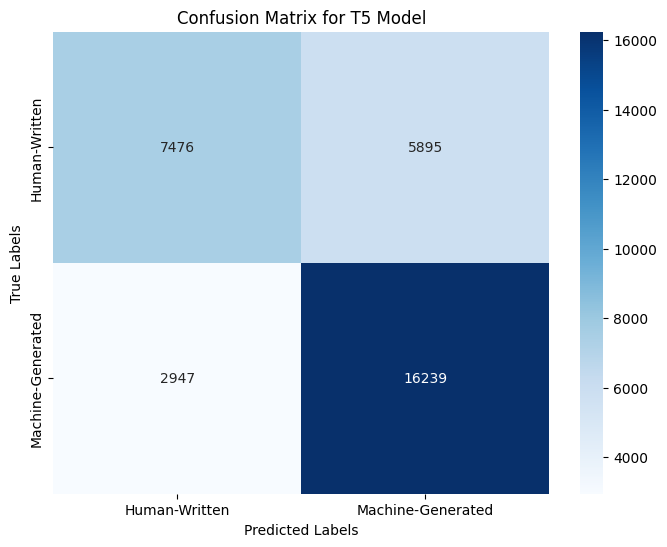

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Human-Written", "Machine-Generated"], yticklabels=["Human-Written", "Machine-Generated"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for T5 Model")
plt.show()

